# Data Exploration and Visualization of NOM Data in NMDC (FT ICR-MS)
This notebook identifies natural organic matter (NOM) data sets in the National Microbiome Data Collaborative (NMDC), filters those datasets based on quality control metrics, and analyzes the molecular composition of the chosen datasets via heatmaps and Van Krevelen plots.
This notebook uses the `nmdc_api_utilities` package (as of March 2025) to do this exploration. It involves using `nmdc_api_utilites` objects to make NMDC API requests easier, and using utility function to help us with data processing tasks. More information about the package can be found [here](https://microbiomedata.github.io/nmdc_api_utilities/)

In [1]:
%%capture
## First need to install locally the nmdc_api_utilities
%pip install nmdc_api_utilities;
## And also install python-dotenv for development use
%pip install python-dotenv

## Set up environment variables
**You can disregard this section of code unless you have interest in testing this on the development API.**

Using pythons python-dotenv package, load the environment variables from the system. This chunk of code is used in the Github CI/CD pipelines to test our development API. The variable can be used when creating `nmdc_api_utilities` objects. If you do not have the environment variable `ENV` set in a .env file, this code with default to the variable "prod" - which tells nmdc_api_utilities to use the production API URL.

In [2]:
# set up environment variables
from dotenv import load_dotenv
import os
load_dotenv()
# load the environment variable ENV. If it does not exist, default to "prod"
ENV = os.environ.get("ENV", "prod")

In [3]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from matplotlib.patches import Patch
import nmdc_api_utilities

## Define a function to split a list into chunks 

Since we will need to use a list of ids to query a new collection in the API, we need to limit the number of ids we put in a query. This function splits a list into chunks of 100. Note that the `chunk_size` has a default of 100, but can be adjusted.

In [4]:
# Define a function to split ids into chunks
def split_list(input_list, chunk_size=100):
    result = []
    
    for i in range(0, len(input_list), chunk_size):
        result.append(input_list[i:i + chunk_size])
        
    return result

## Define a function to get a list of ids from initial results
In order to use the identifiers retrieved from an initial API request in another API request, this function is defined to take the initial request results and use the `id_name` key from the results to create a list of all the ids. The input is the initial result list and the name of the id field.

In [5]:
def get_id_list(result_list: list, id_name: str):
    id_list = []
    for item in result_list:
        if type(item[id_name]) == str:
            id_list.append(item[id_name])
        elif type(item[id_name]) == list:
            for another_item in item[id_name]:
                id_list.append(another_item)

    return id_list

### Gather the IDs for processed NOM results in NMDC by filtering for data objects of type "Direct Infusion FT ICR-MS"

Use the nmdc_api_utilies `DataObjectSearch` to gather processed NOM results. The function `get_record_by_attribute` gets record by input attribute name and value. See the documentation for more details [here](https://microbiomedata.github.io/nmdc_api_utilities/).

We pass in `data_object_type` using a keyword search of “Direct Infusion FT ICR-MS Analysis Results”. Extract the fields `id` (necessary for traversing the NMDC schema), `url` (necessary for pulling data) and `md5_checksum` (used to check uniqueness of data set). The fucntion will create the filter and API request from these paramters.

In [6]:
from nmdc_api_utilities.data_object_search import DataObjectSearch
dos_client = DataObjectSearch(env=ENV)
from nmdc_api_utilities.data_processing import DataProcessing
dp_client = DataProcessing()
processed_nom = dos_client.get_record_by_attribute(attribute_name='data_object_type', attribute_value='Direct Infusion FT-ICR MS Analysis Results', max_page_size=100, fields='id,md5_checksum,url', all_pages=True)
# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_md5_checksum"] = dataobject.pop("md5_checksum")
    dataobject["processed_nom_url"] = dataobject.pop("url")

# convert to df
processed_nom_df = dp_client.convert_to_df(processed_nom)
processed_nom_df


processed_nom_id        processed_nom_md5_checksum  \
0     nmdc:dobj-11-003x7710  0391d9ff37a1926d5cf0eaec126ad4ff   
1     nmdc:dobj-11-00dewm52  2a532dca15798e470103ebd752a0937f   
2     nmdc:dobj-11-00wm3313  3ce562ac512457ea54bdda05a4f01ede   
3     nmdc:dobj-11-01kye625  38930c28eae561bc807bd01823f04167   
4     nmdc:dobj-11-02trja88  e6bafa5fabbebfb0061aa2587e223979   
...                     ...                               ...   
2578  nmdc:dobj-13-zrp1qw41  98b97b78fff542b66e72f4b3f792d80f   
2579  nmdc:dobj-13-zsqpnm92  3e9e19910edb209d211d9f915e36b8cb   
2580  nmdc:dobj-13-zvnmsp76  aec0521d6a36a440e41052f8eadc0d1d   
2581  nmdc:dobj-13-zvzx2462  9f0d52cc46d247b8d2ba12d5842b9fb6   
2582  nmdc:dobj-13-zye5fe51  8ddaeeffe93db9c4258a03e881d329cf   

                                      processed_nom_url  
0     https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...  
1     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
2     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
3     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
4     https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...  
...                                                 ...  
2578  https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...  
2579  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  
2580  https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...  
2581  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  
2582  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  

[2583 rows x 3 columns]

### Continue traversing the NMDC schema by using the list of identifiers from the previous API call to query the next collection

Find the analysis records that produced these processed nom object IDs by matching object `processed_nom_id` to the `has_output` slot with a filter and the WorkflowExecutionSearch object. Also extract the `has_input` slot as it will be used for the next traversal, grabbing the raw data objects that are used as input to the nom analysis records.

In [7]:
from nmdc_api_utilities.workflow_execution_search import WorkflowExecutionSearch
# since we are querying the WorkflowExecution collection, we need to create an instance of it
we_client = WorkflowExecutionSearch(env=ENV)
# use utility function to get a list of the ids from processed_nom
result_ids = get_id_list(processed_nom, "processed_nom_id")
# create a list of lists of ids to query the WorkflowExecutionSearch object
chunked_list = split_list(result_ids)
analysis_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the WorkflowExecutionSearch object looking for data objects where the has_output field is in the chunk of ids from processed_nom
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
    # get the results
    analysis_dataobj += we_client.get_record_by_filter(filter=filter, fields="id,has_input,has_output", max_page_size=100, all_pages=True)

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = dp_client.convert_to_df(analysis_dataobj)
analysis_dataobj_df

analysis_id  \
0     nmdc:wfnom-11-dv3wck24.1   
1     nmdc:wfnom-11-0mqv1c63.1   
2     nmdc:wfnom-11-twkd5a03.1   
3     nmdc:wfnom-11-ftaq2319.1   
4     nmdc:wfnom-11-2dcp9q04.1   
...                        ...   
2578  nmdc:wfnom-13-08q56295.1   
2579  nmdc:wfnom-13-yy5yqx31.1   
2580  nmdc:wfnom-13-4xrsd836.1   
2581  nmdc:wfnom-13-h0r53g59.1   
2582  nmdc:wfnom-13-4vmrb525.1   

                                  analysis_has_input      analysis_has_output  
0     [nmdc:dobj-11-2ysghy98, nmdc:dobj-11-bmeg5b74]  [nmdc:dobj-11-003x7710]  
1                            [nmdc:dobj-11-3hfzr472]  [nmdc:dobj-11-00dewm52]  
2                            [nmdc:dobj-11-2mk4qf09]  [nmdc:dobj-11-00wm3313]  
3                            [nmdc:dobj-11-7wynt887]  [nmdc:dobj-11-01kye625]  
4                            [nmdc:dobj-11-ge6pre79]  [nmdc:dobj-11-02trja88]  
...                                              ...                      ...  
2578                         [nmdc:dobj-13-vg0tgv60]  [nmdc:dobj-13-zrp1qw41]  
2579                         [nmdc:dobj-13-w15zk074]  [nmdc:dobj-13-zsqpnm92]  
2580                         [nmdc:dobj-13-3rmgcm64]  [nmdc:dobj-13-zvnmsp76]  
2581                         [nmdc:dobj-13-m3zkxg02]  [nmdc:dobj-13-zvzx2462]  
2582                         [nmdc:dobj-13-60z8rt70]  [nmdc:dobj-13-zye5fe51]  

[2583 rows x 3 columns]

Find the raw data objects used as input for these analysis records by matching the analysis record's `has_input` slot to the `id` slot in the collection `data_object_set`. Create a DataObjectSearch object to do so.

Workflows can take multiple inputs (eg. configuration or parameter files) in addition to the raw data, so we will filter the results to only keep raw data object IDs.

In [8]:
# use utility function to get a list of the ids from raw_dataobj
result_ids = get_id_list(analysis_dataobj, "analysis_has_input")
# create a list of lists of ids to query the DataObjectSearch object
chunked_list = split_list(result_ids)
raw_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the DataObjectSearch object looking for data objects where the id field is in the chunk of ids from analysis_dataobj
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    raw_dataobj += dos_client.get_record_by_filter(filter=filter, fields="id,name,data_object_type", max_page_size=100, all_pages=True)

# clarify names
for dataobject in raw_dataobj:
    dataobject["raw_id"] = dataobject.pop("id")
    dataobject["raw_name"] = dataobject.pop("name")

# Filter out parameter files (leave NAs in case raw data files are missing a label)
param_dataobj = [file for file in raw_dataobj if 'data_object_type' in file and file['data_object_type'] == 'Analysis Tool Parameter File']
raw_dataobj = [file for file in raw_dataobj if file not in param_dataobj]

raw_df = dp_client.convert_to_df(raw_dataobj)

raw_df


data_object_type                 raw_id  \
0     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-04embv91   
1     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-04ny1n21   
2     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-09p17z03   
3     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-0cmhqk17   
4     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-10madc26   
...                                  ...                    ...   
2578  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-vcsgr863   
2579  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-vg0tgv60   
2580  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-vya84d93   
2581  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-w15zk074   
2582  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-13-zazrqk87   

                                               raw_name  
0     Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...  
1     Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...  
2     Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...  
3     WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...  
4     WHONDRS_S19S_015_17Mar20_Alder_Infuse_P2_1_01_...  
...                                                 ...  
2578        output: Brodie_181_MeOH_R2_21Mar19_HESI_Neg  
2579  output: SBR_FC_S3_30-40_H2Oext_13Oct15_Leopard...  
2580           output: Brodie_152_w_r2_29Jan19_HESI_neg  
2581  output: Brodie_135A_H2O_15Oct18_IAT_p1_1_01_35894  
2582           output: Brodie_185_w_r1_01Feb19_HESI_neg  

[2583 rows x 3 columns]

Find the data generation records capturing mass spectrometry information for these raw data objects by matching the data object's `id` slot to the `has_output` slot in the collection `data_generation_set`. Create a DataGenerationSearch object to do so. Once again extract the `has_input` slot as it will be used for the next traversal, grabbing the biosample data objects that are used as input to the data generation records.

In [9]:
from nmdc_api_utilities.data_generation_search import DataGenerationSearch
dgs_client = DataGenerationSearch(env=ENV)
# use utility function to get a list of the ids from raw_dataobj
result_ids = get_id_list(raw_dataobj, "raw_id")
# create a list of lists of ids to query the DataGenerationSearch object
chunked_list = split_list(result_ids)
datageneration_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the DataGenerationSearch object looking for data objects that have the raw_id in the has_output field
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
    # get the results
    datageneration_dataobj += dgs_client.get_record_by_filter(filter=filter, fields="id,has_input,has_output", max_page_size=100, all_pages=True)

# clarify names
for dataobject in datageneration_dataobj:
    dataobject["datageneration_id"] = dataobject.pop("id")
    dataobject["datageneration_has_output"] = dataobject.pop("has_output")
    dataobject["datageneration_has_input"] = dataobject.pop("has_input")
# convert to data frame
datageneration_dataobj_df = dp_client.convert_to_df(datageneration_dataobj)
datageneration_dataobj_df

datageneration_id datageneration_has_output  \
0     nmdc:omprc-11-vfj8z279   [nmdc:dobj-11-01q67939]   
1     nmdc:omprc-11-adjx8k29   [nmdc:dobj-11-04embv91]   
2     nmdc:omprc-11-w1kvtj73   [nmdc:dobj-11-04ny1n21]   
3     nmdc:omprc-11-rj3bqn04   [nmdc:dobj-11-09p17z03]   
4     nmdc:omprc-11-a1szxs11   [nmdc:dobj-11-0cmhqk17]   
...                      ...                       ...   
2578  nmdc:omprc-11-077nww93   [nmdc:dobj-13-zjrg8w43]   
2579  nmdc:omprc-11-s9xtq276   [nmdc:dobj-13-zpzv3z08]   
2580  nmdc:omprc-13-8hsd4d19   [nmdc:dobj-13-zymvcs73]   
2581  nmdc:omprc-13-ef1v6r85   [nmdc:dobj-13-zz1a8884]   
2582  nmdc:omprc-13-xemx6b61   [nmdc:dobj-13-zzzyae97]   

       datageneration_has_input  
0        [nmdc:bsm-11-zdd5hz60]  
1     [nmdc:procsm-11-xsfbpz40]  
2     [nmdc:procsm-11-f7kfky42]  
3     [nmdc:procsm-11-ckacrz04]  
4        [nmdc:bsm-11-q8jzws69]  
...                         ...  
2578  [nmdc:procsm-11-s1ypy935]  
2579  [nmdc:procsm-11-2nexmt97]  
2580  [nmdc:procsm-11-4bpnn544]  
2581  [nmdc:procsm-11-8hrn7z73]  
2582  [nmdc:procsm-11-t7qjg604]  

[2583 rows x 3 columns]

Find the inputs for these data generation records based on whether they are biosamples or processed samples. This can vary depending on if a sample went through any material processing prior to mass spectrometry. 

In [10]:
datageneration_dataobj_df['datageneration_has_input'].explode().str.extract('nmdc:(procsm|bsm)')[0].value_counts(dropna=False)

0
procsm    1884
bsm        699
Name: count, dtype: int64

Find the biosample from which each processed sample originates by creating a MaterialProcessingSet and iterating through material processing steps until the `has_input` value is a biosample.

In [11]:
from nmdc_api_utilities.material_processing_search import MaterialProcessingSearch
mp_client = MaterialProcessingSearch()

# use utility function to get a unique list of the ids from datageneration_dataobj
result_ids = list(set(get_id_list(datageneration_dataobj, "datageneration_has_input")))

# separate ids into processedsample_ids and biosample_ids
processedsamples = [item for item in result_ids if 'nmdc:procsm' in item]
biosamples = [item for item in result_ids if 'nmdc:bsm' in item]

# dataframe of intermediate processed samples to track
tracking_ps = pd.DataFrame({'intermediate_ps':processedsamples,'dg_input':processedsamples})

# dataframe of tracked biosample inputs mapped to the input given to data generation
tracked = [pd.DataFrame({'biosample_id':biosamples,'dg_input':biosamples})]


while tracking_ps.shape[0]>0:

    # get api calls for these processed samples
    chunked_list = split_list(tracking_ps['intermediate_ps'].tolist())
    mp_dataobj = []
    for chunk in chunked_list:
        filter_list = dp_client._string_mongo_list(chunk)
        filter = f'{{"has_output": {{"$in": {filter_list}}}}}'
        mp_dataobj += mp_client.get_record_by_filter(filter=filter, fields='has_input,has_output', max_page_size=100, all_pages=True)

    mp_dataobj = dp_client.convert_to_df(mp_dataobj).explode('has_input').explode('has_output').merge(tracking_ps,right_on='intermediate_ps',left_on='has_output').drop(['has_output','id'],axis=1)

    # separate steps with biosample vs processed sample inputs
    biosample_input = mp_dataobj[mp_dataobj['has_input'].str.contains('nmdc:bsm',na=False)].drop('intermediate_ps',axis=1).rename(columns={'has_input':'biosample_id'})
    processedsample_input = mp_dataobj[mp_dataobj['has_input'].str.contains('nmdc:procsm',na=False)].drop('intermediate_ps',axis=1).rename(columns={'has_input':'intermediate_ps'}) # new ps input is now intermediate_ps

    # update tracking_ps
    tracking_ps = processedsample_input

    # update tracked to those steps with a biosample input
    if not biosample_input.empty:
        tracked.append(biosample_input)

datageneration_inputupdate_df = pd.concat(tracked, ignore_index=True).merge(datageneration_dataobj_df.explode('datageneration_has_input').explode('datageneration_has_output'),left_on='dg_input',right_on='datageneration_has_input').\
    drop(['dg_input','datageneration_has_input'],axis=1).drop_duplicates()
datageneration_inputupdate_df

biosample_id       datageneration_id datageneration_has_output
0     nmdc:bsm-11-0n5f5q18  nmdc:omprc-11-wvcabm20     nmdc:dobj-11-ehx7je90
1     nmdc:bsm-11-0n5f5q18  nmdc:omprc-11-akgj7s24     nmdc:dobj-11-z8mtgn65
2     nmdc:bsm-11-yjatyq26  nmdc:omprc-11-t396na93     nmdc:dobj-11-f3wn8968
3     nmdc:bsm-11-465zby33  nmdc:omprc-11-pbche753     nmdc:dobj-11-cdbjns82
4     nmdc:bsm-11-nkc9vr94  nmdc:omprc-11-czn6rx02     nmdc:dobj-11-y0z92c72
...                    ...                     ...                       ...
3653  nmdc:bsm-11-beyrfr12  nmdc:omprc-11-kdc0mg16     nmdc:dobj-11-thscxm02
3654  nmdc:bsm-11-c59t0s62  nmdc:omprc-11-qdgwtq70     nmdc:dobj-11-mw2wk058
3655  nmdc:bsm-11-5x1tcz23  nmdc:omprc-11-gsrsgp44     nmdc:dobj-11-g0apzc75
3656  nmdc:bsm-11-tpdee537  nmdc:omprc-11-z7eg8v92     nmdc:dobj-11-zm2m8971
3657  nmdc:bsm-11-f2d61z81  nmdc:omprc-11-61xw3z63     nmdc:dobj-11-ynz2wv33

[2583 rows x 3 columns]

Find the biosample data objects used as input for these data generation records by matching the processing record's `has_input` slot to the `id` slot in the collection `biosample_set`. Create a BiosampleSearch object to do so. Query all fields in this API call by excluding the fields parameter and utilize informative columns to group biosamples into a `type`. 

In [12]:
from nmdc_api_utilities.biosample_search import BiosampleSearch
bs_client = BiosampleSearch(env=ENV)

# get a list of the biosample ids from datageneration_inputupdate_df
result_ids = datageneration_inputupdate_df["biosample_id"].unique().tolist()
# create a list of lists of ids to query the BiosampleSearch object
chunked_list = split_list(result_ids)
biosample_dataobj = []
# loop through the chunked list of ids
for chunk in chunked_list:
    # create the filter - query the BiosampleSearch object looking for data objects where the id is in the chunk of ids from datageneration_dataobj
    filter_list = dp_client._string_mongo_list(chunk)
    filter = f'{{"id": {{"$in": {filter_list}}}}}'
    # get the results
    biosample_dataobj += bs_client.get_record_by_filter(filter=filter, max_page_size=100, all_pages=True)

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = dp_client.convert_to_df(biosample_dataobj)

biosample_dataobj_df

type                           name  \
0     nmdc:Biosample  WHONDRS_S19S_0042_SED_FIELD_D   
1     nmdc:Biosample    WHONDRS_S19S_0039_SED_INC_D   
2     nmdc:Biosample    WHONDRS_S19S_0041_SED_INC_M   
3     nmdc:Biosample    WHONDRS_S19S_0100_SED_INC_D   
4     nmdc:Biosample    WHONDRS_S19S_0050_SED_INC_M   
...              ...                            ...   
1031  nmdc:Biosample                  Lybrand_FT_52   
1032  nmdc:Biosample       Lybrand_Permafrost_Y1_35   
1033  nmdc:Biosample                  Lybrand_FT_45   
1034  nmdc:Biosample       Lybrand_Permafrost_HE_03   
1035  nmdc:Biosample       Lybrand_Permafrost_Y1_55   

                                            description  \
0     River sediment microbial communities from Shar...   
1     River sediment microbial communities from East...   
2     River sediment microbial communities from Croo...   
3     River sediment microbial communities from East...   
4     River sediment microbial communities from Oksr...   
...                                                 ...   
1031                          Lybrand NEON (EMSL 50267)   
1032                               Lybrand (EMSL 50267)   
1033                          Lybrand NEON (EMSL 50267)   
1034                          Lybrand NEON (EMSL 50267)   
1035                               Lybrand (EMSL 50267)   

          associated_studies  \
0     [nmdc:sty-11-5tgfr349]   
1     [nmdc:sty-11-5tgfr349]   
2     [nmdc:sty-11-5tgfr349]   
3     [nmdc:sty-11-5tgfr349]   
4     [nmdc:sty-11-5tgfr349]   
...                      ...   
1031  [nmdc:sty-11-db67n062]   
1032  [nmdc:sty-11-db67n062]   
1033  [nmdc:sty-11-db67n062]   
1034  [nmdc:sty-11-db67n062]   
1035  [nmdc:sty-11-db67n062]   

                                        env_broad_scale  \
0     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
1     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
2     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
3     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
4     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
...                                                 ...   
1031  {'has_raw_value': 'ENVO:00000446', 'term': {'i...   
1032  {'has_raw_value': 'ENVO:00000446', 'term': {'i...   
1033  {'has_raw_value': 'ENVO:00000446', 'term': {'i...   
1034  {'has_raw_value': 'ENVO:00000446', 'term': {'i...   
1035  {'has_raw_value': 'ENVO:00000446', 'term': {'i...   

                                        env_local_scale  \
0     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
1     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
2     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
3     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
4     {'type': 'nmdc:ControlledIdentifiedTermValue',...   
...                                                 ...   
1031  {'has_raw_value': 'ENVO:01000869', 'term': {'i...   
1032  {'has_raw_value': 'ENVO:01000219', 'term': {'i...   
1033  {'has_raw_value': 'ENVO:01000869', 'term': {'i...   
1034  {'has_raw_value': 'ENVO:01000861', 'term': {'i...   
1035  {'has_raw_value': 'ENVO:01000219', 'term': {'i...   

                                             env_medium      ecosystem  \
0     {'type': 'nmdc:ControlledIdentifiedTermValue',...  Environmental   
1     {'type': 'nmdc:ControlledIdentifiedTermValue',...  Environmental   
2     {'type': 'nmdc:ControlledIdentifiedTermValue',...  Environmental   
3     {'type': 'nmdc:ControlledIdentifiedTermValue',...  Environmental   
4     {'type': 'nmdc:ControlledIdentifiedTermValue',...  Environmental   
...                                                 ...            ...   
1031  {'has_raw_value': 'ENVO:00001998', 'term': {'i...            NaN   
1032  {'has_raw_value': 'ENVO:00001998', 'term': {'i...            NaN   
1033  {'has_raw_value': 'ENVO:00001998', 'term': {'i...            NaN   
1034  {'has_raw_value': 'ENVO:00001998', 'term': {'i...            NaN   
1035  {'has_raw_value': 'ENVO

Assign a general type for each sample by parsing their ENVO IDs. This was done manually by searching ENVO ID's on the [ontology search website](https://www.ebi.ac.uk/ols4/ontologies/envo).

In [13]:
biosample_dataobj_flat=pd.json_normalize(biosample_dataobj)
biosample_dataobj_flat_df=dp_client.convert_to_df(biosample_dataobj_flat)

biosample_dataobj_flat_df['sample_type']=""

biosample_dataobj_flat_df['env_medium.term.id'].drop_duplicates()

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('soil', na = False),'sample_type'] = 'soil'

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002261","ENVO:00001998","ENVO:00002259",
                                                                                    "ENVO:01001616","ENVO:00005750","ENVO:00005761",
                                                                                    "ENVO:00005760","ENVO:00005773","ENVO:00005802",
                                                                                    "ENVO:00005774"]),'sample_type'] = 'soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002042"]),'sample_type'] = 'water'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002007"]),'sample_type'] = 'sediment'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:01000017"]),'sample_type'] = 'sand'

#filter to desired metadata columns
biosample_dataobj_flat_df=biosample_dataobj_flat_df[['biosample_id','geo_loc_name.has_raw_value','env_medium.term.name','env_medium.term.id','sample_type']]

biosample_dataobj_flat_df

biosample_id        geo_loc_name.has_raw_value  \
0     nmdc:bsm-11-00esf117            USA: Florida, Flamingo   
1     nmdc:bsm-11-02323679         USA: Tennessee, Oak Ridge   
2     nmdc:bsm-11-03kkns72           USA: Oregon, Prineville   
3     nmdc:bsm-11-0674q034      USA: Colorado, Crested Butte   
4     nmdc:bsm-11-06q50228  USA: Alaska, North Slope Borough   
...                    ...                               ...   
1031  nmdc:bsm-11-w51n4t52                   USA: AK, Denali   
1032  nmdc:bsm-11-xbnfea23     USA: AK, Fairbanks North Star   
1033  nmdc:bsm-11-xjn64a84                   USA: AK, Denali   
1034  nmdc:bsm-11-yvy4ef54                USA: Alaska, Healy   
1035  nmdc:bsm-11-zrmt9512     USA: AK, Fairbanks North Star   

     env_medium.term.name env_medium.term.id sample_type  
0                sediment      ENVO:00002007    sediment  
1                sediment      ENVO:00002007    sediment  
2                sediment      ENVO:00002007    sediment  
3                sediment      ENVO:00002007    sediment  
4                sediment      ENVO:00002007    sediment  
...                   ...                ...         ...  
1031                 soil      ENVO:00001998        soil  
1032                 soil      ENVO:00001998        soil  
1033                 soil      ENVO:00001998        soil  
1034                 soil      ENVO:00001998        soil  
1035                 soil      ENVO:00001998        soil  

[1036 rows x 5 columns]

### Create final data frame of relevant metadata and NMDC schema information for each NOM processed data object

Create merged dataframe with results from schema traversal and metadata using the DataProcessing object created earlier. 

In [14]:
#match all processed nom objects (via processed_nom_id) to analysis objects (via analysis_has_output) and expand lists has_input and has_output
processed_obj_to_analysis_df=dp_client.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_id","analysis_has_output")

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=dp_client.merge_df(raw_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input")

#match processed_obj_to_raw_df (via raw_id) to data generation objects (via datageneration_has_output) and expand lists has_input and has_output
processed_obj_to_datagen_df=dp_client.merge_df(processed_obj_to_raw_df,datageneration_inputupdate_df,"raw_id","datageneration_has_output")

#match biosample objects (via biosample_id) to processed_obj_to_datagen_df (via datageneration_has_input)
merged_df=dp_client.merge_df(biosample_dataobj_flat_df,processed_obj_to_datagen_df,"biosample_id","biosample_id")

merged_df

biosample_id        geo_loc_name.has_raw_value  \
0     nmdc:bsm-11-00esf117            USA: Florida, Flamingo   
1     nmdc:bsm-11-02323679         USA: Tennessee, Oak Ridge   
2     nmdc:bsm-11-03kkns72           USA: Oregon, Prineville   
3     nmdc:bsm-11-0674q034      USA: Colorado, Crested Butte   
4     nmdc:bsm-11-06q50228  USA: Alaska, North Slope Borough   
...                    ...                               ...   
2578  nmdc:bsm-11-xjn64a84                   USA: AK, Denali   
2579  nmdc:bsm-11-yvy4ef54                USA: Alaska, Healy   
2580  nmdc:bsm-11-yvy4ef54                USA: Alaska, Healy   
2581  nmdc:bsm-11-zrmt9512     USA: AK, Fairbanks North Star   
2582  nmdc:bsm-11-zrmt9512     USA: AK, Fairbanks North Star   

     env_medium.term.name env_medium.term.id sample_type  \
0                sediment      ENVO:00002007    sediment   
1                sediment      ENVO:00002007    sediment   
2                sediment      ENVO:00002007    sediment   
3                sediment      ENVO:00002007    sediment   
4                sediment      ENVO:00002007    sediment   
...                   ...                ...         ...   
2578                 soil      ENVO:00001998        soil   
2579                 soil      ENVO:00001998        soil   
2580                 soil      ENVO:00001998        soil   
2581                 soil      ENVO:00001998        soil   
2582                 soil      ENVO:00001998        soil   

                        data_object_type                 raw_id  \
0     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-m2zeq581   
1     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-k460cb55   
2     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-yyg7p460   
3     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-96x93e16   
4     Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-s7gxcg35   
...                                  ...                    ...   
2578  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-5kvftw17   
2579  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-ebs8xm07   
2580  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-kfwj3h42   
2581  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-fqs8nt62   
2582  Direct Infusion FT ICR-MS Raw Data  nmdc:dobj-11-1sf1e219   

                                               raw_name  \
0     WHONDRS_S19S_114_17Mar20_Alder_Infuse_P2_1_01_...   
1     S19S_0039_SED_INC_ICR-D_26Dec19_Alder_Infuse_p...   
2     S19S_0041_SED_INC_ICR-M_30Dec19_Alder_Infuse_p...   
3     S19S_0100_SED_INC_ICR-D_26Dec19_Alder_Infuse_p...   
4     S19S_0050_SED_INC_ICR-M_26Dec19_Alder_Infuse_p...   
...                                                 ...   
2578  Lybrand_FT_45_C_30Aug19_Alder_Infuse_p05_1_01_...   
2579  Lybrand_Permafrost_HE_03_H2O_11Dec19_Alder_Inf...   
2580  Lybrand_Permafrost_HE_03_CHCl3_13Dec19_Alder_I...   
2581  Lybrand_Permafrost_Y1_55_H2O_11Dec19_Alder_Inf...   
2582  Lybrand_Permafrost_Y1_55_CHCl3_12Dec19_Alder_I...   

           processed_nom_id        processed_nom_md5_checksum  \
0     nmdc:dobj-11-ensmr363  c12e6b88e77fa57a29b2f1fcedb5eb87   
1     nmdc:dobj-11-ntxd5579  5b7378916f238b02ba2b98e17583fcc8   
2     nmdc:dobj-11-9pfpjy34  7fbca784fe1d711cee79fc13748e9288   
3     nmdc:dobj-11-267t2v66  adb3e8f24f07311fba132f214b8059eb   
4     nmdc:dobj-11-86fak217  e8affb64154d34ecf370867d8b235dcd   
...                     ...                               ...   
2578  nmdc:dobj-11-t1h4cw46  7c223c6ba08244ce78551868c9ee27dd   
2579  nmdc:dobj-11-tz1xrs45  9c96e7782d0f59ca62ee30b9756efa76   
2580  nmdc:dobj-11-xcf8wm23  9e43be1003e35ff515b93fb7dfe1d2a7   
2581  nmdc:dobj-11-7ry41584  0ce74de9694df0ef0f96eee33edb6206   
2582  nmdc:dobj-11-pk0erp03  381899cf7208475189abe72b1ab98cf0   

                                      processed_nom_url  \
0     https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...   
1     https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...   
2     https://nmdcdemo.emsl.pnnl.gov/nom/grow/result

Use the md5_checksum to check that each row/processed NOM object has an associated url that is unique

In [15]:
#are there any md5_checksum values that occur more than once (i.e. are associated with more than one processed nom id)
len(merged_df[merged_df.duplicated('processed_nom_md5_checksum')]['processed_nom_md5_checksum'].unique())==0

True

Clean up final dataframe, removing unneeded/intermediate identifier columns from schema traversal.

In [16]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","sample_type","processed_nom_url"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))

# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicate rows when keeping only necessary columns (should remove none)
final_df=merged_df_cleaned.drop_duplicates(keep="first").sort_values(by='processed_nom_id').reset_index(drop=True)

final_df

biosample_id sample_type       processed_nom_id  \
0     nmdc:bsm-11-cwey4y35        soil  nmdc:dobj-11-003x7710   
1     nmdc:bsm-11-sk8vv550        soil  nmdc:dobj-11-00dewm52   
2     nmdc:bsm-11-yzgc1096        soil  nmdc:dobj-11-00wm3313   
3     nmdc:bsm-11-e3m5pt51        soil  nmdc:dobj-11-01kye625   
4     nmdc:bsm-11-80jr8p82        soil  nmdc:dobj-11-02trja88   
...                    ...         ...                    ...   
2578  nmdc:bsm-13-tr7n0581        sand  nmdc:dobj-13-zrp1qw41   
2579  nmdc:bsm-11-hf7a3g98        soil  nmdc:dobj-13-zsqpnm92   
2580  nmdc:bsm-13-4pbbvj63        sand  nmdc:dobj-13-zvnmsp76   
2581  nmdc:bsm-11-mbnqn650        soil  nmdc:dobj-13-zvzx2462   
2582  nmdc:bsm-11-k05a2416        soil  nmdc:dobj-13-zye5fe51   

                                      processed_nom_url  
0     https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...  
1     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
2     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
3     https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
4     https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...  
...                                                 ...  
2578  https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...  
2579  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  
2580  https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...  
2581  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  
2582  https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  

[2583 rows x 4 columns]

Randomly select datasets from each `sample_type` on which to calculate quality control statistics

In [17]:
dataset_counts = final_df[['processed_nom_id','sample_type']].drop_duplicates().value_counts('sample_type')
min_n = min(pd.DataFrame(dataset_counts)['count'])

#set sampling size to 50 or the smallest sample count, whichever value is smaller
if 50 < min_n:
    n = 50
else:
    n = min_n

#list the different types
list_type=dataset_counts.index.tolist()

#for each type, randomly sample n data sets and save them into list
random_subset=[]
for type in list_type:
    #each processed ID and sample type
    sample_type=final_df[['processed_nom_id','sample_type']].drop_duplicates()
    #filter to current sample type
    sample_type=sample_type[sample_type['sample_type']==type]
    #randomly sample n processed IDs in current sample type
    sample_type=sample_type.sample(n=n, random_state=2)
    #save
    random_subset.append(sample_type)

#resave list as dataframe
random_subset=pd.concat(random_subset).reset_index(drop=True)

#remerge rest of the data for the sampled data sets
final_df=random_subset.merge(final_df,on=['processed_nom_id','sample_type'],how="left")

final_df

processed_nom_id sample_type          biosample_id  \
0    nmdc:dobj-11-dn0zxg92        soil  nmdc:bsm-11-xvnjap82   
1    nmdc:dobj-11-bzg32p17        soil  nmdc:bsm-11-rrmwch98   
2    nmdc:dobj-11-nvb86885        soil  nmdc:bsm-11-pdtj6h88   
3    nmdc:dobj-11-wzyfp957        soil  nmdc:bsm-11-6p6mhh86   
4    nmdc:dobj-13-9gwc6a87        soil  nmdc:bsm-11-q71pns38   
..                     ...         ...                   ...   
195  nmdc:dobj-13-cw804j48        sand  nmdc:bsm-13-ap544f22   
196  nmdc:dobj-13-gatmnn76        sand  nmdc:bsm-13-xvyhr616   
197  nmdc:dobj-13-nsfrf494        sand  nmdc:bsm-13-sy2a9t67   
198  nmdc:dobj-13-qdpv9v42        sand  nmdc:bsm-13-mk8xn190   
199  nmdc:dobj-13-bdyz9y36        sand  nmdc:bsm-13-sy2a9t67   

                                     processed_nom_url  
0    https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...  
1    https://nmdcdemo.emsl.pnnl.gov/nom/neon/lybran...  
2    https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
3    https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...  
4    https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...  
..                                                 ...  
195  https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...  
196  https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...  
197  https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...  
198  https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...  
199  https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...  

[200 rows x 4 columns]

### Calculate quality control statistics on the sampled processed nom results (this can take a while to run)

Explore what the files associated with these NOM data objects look like. 

In [18]:
#example file
url=final_df.iloc[0]["processed_nom_url"]

#pull data as csv using url
response = requests.get(url)
csv_data = StringIO(response.text)
csv_df = pd.read_csv(csv_data)
csv_data.close()
csv_df

Index         m/z  Calibrated m/z  Calculated m/z   Peak Height  \
0          0  900.125820      900.126036      900.126495  1.345499e+06   
1          4  899.649633      899.649848      899.649888  1.014133e+06   
2          5  899.634336      899.634551      899.634770  1.213550e+06   
3          6  899.322820      899.323034      899.322557  9.292093e+05   
4          7  899.145691      899.145905      899.146502  1.297759e+06   
...      ...         ...             ...             ...           ...   
10332  10332  105.150552      105.150491             NaN  9.256716e+05   
10333  10333  105.047562      105.047501             NaN  9.549125e+05   
10334  10334  104.965050      104.964989             NaN  1.008435e+06   
10335  10335  104.014316      104.014256             NaN  9.708627e+05   
10336  10336  102.197131      102.197074             NaN  1.071442e+06   

          Peak Area  Resolving Power       S/N  Ion Charge  m/z Error (ppm)  \
0      16585.425742     7.632381e+04  8.758887          -1        -0.510143   
1      10281.746451     7.636398e+04  6.601772          -1        -0.043821   
2      11139.424542     9.163838e+04  7.899927          -1        -0.242915   
3      13168.509602     6.547870e+04  6.048938          -1         0.531086   
4      10598.710188     1.146105e+05  8.448112          -1        -0.663726   
...             ...              ...       ...         ...              ...   
10332    129.799973     7.840292e+05  6.025908          -1              NaN   
10333    131.008418     6.539981e+05  6.216260          -1              NaN   
10334    182.325337     6.545125e+05  6.564676          -1              NaN   
10335    100.081030     9.907425e+05  6.320091          -1              NaN   
10336    107.653102     1.008359e+06  6.974842          -1              NaN   

       ...       Ion Type  Is Isotopologue  Mono Isotopic Index  \
0      ...  de-protonated              0.0                  NaN   
1      ...  de-protonated              0.0                  NaN   
2      ...  de-protonated              0.0                  NaN   
3      ...  de-protonated              0.0                  NaN   
4      ...  de-protonated              0.0                  NaN   
...    ...            ...              ...                  ...   
10332  ...            NaN              NaN                  NaN   
10333  ...            NaN              NaN                  NaN   
10334  ...            NaN              NaN                  NaN   
10335  ...            NaN              NaN                  NaN   
10336  ...            NaN              NaN                  NaN   

       Molecular Formula     C     H     O    S    N  13C  
0         C42 H31 O22 N1  42.0  31.0  22.0  NaN  1.0  NaN  
1         C47 H96 O13 S1  47.0  96.0  13.0  1.0  NaN  NaN  
2             C64 H84 O3  64.0  84.0   3.0  NaN  NaN  NaN  
3             C59 H48 O9  59.0  48.0   9.0  NaN  NaN  NaN  
4            C47 H32 O19  47.0  32.0  19.0  NaN  NaN  NaN  
...                  ...   ...   ...   ...  ...  ...  ...  
10332                NaN   NaN   NaN   NaN  NaN  NaN  NaN  
10333                NaN   NaN   NaN   NaN  NaN  NaN  NaN  
10334                NaN   NaN   NaN   NaN  NaN  NaN  NaN  
10335                NaN   NaN   NaN   NaN  NaN  NaN  NaN  
10336                NaN   NaN   NaN   NaN  NaN  NaN  NaN  

[10337 rows x 27 columns]

Calculate % of peaks assigned and extract molecular formulas, H/C and O/C values from the processed NOM data sets. If there are multiple matches for a m/z peak, filter to the match with the highest confidence score. 


In [19]:
errors = {}
iteration_counter = 0
mol_dict=[]
multi_peakmatch_file_counter=0
multi_peakmatch_peak_counter=0

for index, row in final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    #save data set level information
    url = row["processed_nom_url"]
    processed=row['processed_nom_id']
    sample_type=row['sample_type']

    try:
        
        # get CSV data using URL
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        #calculate assigned peak percent
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)

        # If there are no rows, don't include this csv, skip to the next one
        if assigned + unassigned == 0:
            print(f"No peaks found in {processed}, skipping file")
            continue
        
        # If there are some rows, and no assigned peaks, the data might fail the shape assertions and break the notebook
        # which is not informative since it would get quality filtered out anyway. Skip to the next one
        elif unassigned > 0 and assigned == 0:
            print(f"No assigned peaks found in {processed}, skipping file")
            continue

        # If there are some rows, and at least one assigned peak, assert that the important columns are correct
        # This we DO want to break if it's wrong
        elif assigned > 0:

            # Workflow Output Tests
            # assert that all four columns are found in the file
            assert set(['Molecular Formula','H/C','O/C','Confidence Score']).issubset(csv_df.columns), "Workflow output does not contain the required columns. Check for workflow changes"

            # assert that H/C and O/C and Confidence Score are numeric
            assert pd.api.types.is_numeric_dtype(csv_df['H/C']), "Column 'H/C' is not numeric. Check for workflow changes"
            assert pd.api.types.is_numeric_dtype(csv_df['O/C']), "Column 'O/C' is not numeric. Check for workflow changes"
            assert pd.api.types.is_numeric_dtype(csv_df['Confidence Score']), "Column 'Confidence Score' is not numeric. Check for workflow changes"
            assert pd.api.types.is_object_dtype(csv_df['Molecular Formula']), "Column 'Molecular Formula' is not a string. Check for workflow changes"
        


        #check if any peaks (m/z) have multiple matches. if so take highest scoring match

        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        multi_peakmatch_peak_counter+=len(dup_peaks)
        #if there are duplicate peaks:
        if len(dup_peaks) > 0:
            multi_peakmatch_file_counter+=1
            #group cv_df by m/z and filter to max confidence score
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            #merge back with original df (that has all columns) to filter duplicate peak entries
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])


        #make dictionary
        #columns to be made into lists
        mol_df=csv_df[['Molecular Formula','H/C','O/C','Confidence Score']]

        #drop unassigned peaks
        mol_df=mol_df.dropna(subset='Molecular Formula')

        #append dictionary
        mol_dict.append({'processed':processed,
                         'sample_type':sample_type,
                         'assigned_peak_count':assigned,
                         'assigned_perc':assigned_perc,
                         'mol_form':mol_df['Molecular Formula'].to_list(),
                         'H/C':mol_df['H/C'].to_list(),
                         'O/C':mol_df['O/C'].to_list(),
                         'Confidence Score':mol_df['Confidence Score'].to_list()
                        })
    
    #if error print info
    except AssertionError as ae:
        print(f"Assertion error occurred: {ae}")
        errors["processed_id"] = processed
        errors["url"] = url
        break

    #if error print info
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["processed_id"] = processed
        errors["url"] = url
        continue

#turn dictionaries into dataframes
nom_summary_df=pd.DataFrame(mol_dict)

nom_summary_df


Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows


processed sample_type  assigned_peak_count  assigned_perc  \
0    nmdc:dobj-11-dn0zxg92        soil                 4150       0.401470   
1    nmdc:dobj-11-bzg32p17        soil                 2320       0.420442   
2    nmdc:dobj-11-nvb86885        soil                 2466       0.695628   
3    nmdc:dobj-11-wzyfp957        soil                 2969       0.757205   
4    nmdc:dobj-13-9gwc6a87        soil                  104       0.832000   
..                     ...         ...                  ...            ...   
195  nmdc:dobj-13-cw804j48        sand                   11       0.113402   
196  nmdc:dobj-13-gatmnn76        sand                   37       0.389474   
197  nmdc:dobj-13-nsfrf494        sand                   13       0.168831   
198  nmdc:dobj-13-qdpv9v42        sand                    8       0.163265   
199  nmdc:dobj-13-bdyz9y36        sand                  318       0.850267   

                                              mol_form  \
0    [C42 H31 O22 N1, C47 H96 O13 S1, C64 H84 O3, C...   
1    [C8 H14 O2, C8 H16 O2, C6 H10 O4, C7 H14 O3, C...   
2    [C6 H10 O3, C6 H12 O3, C7 H6 O3, C7 H10 O3, C7...   
3    [C7 H6 O2, C5 H7 O3 N1, C6 H10 O3, C6 H12 O3, ...   
4    [C6 H13 O6 S1 N1, C12 H20 O4, C13 H18 O4, C13 ...   
..                                                 ...   
195  [C33 H29 O5 S1 N1, C18 H32 O16, C35 H20 O4, C2...   
196  [C50 H36 O7 S1, C33 H50 O19, C43 H36 O10, C52 ...   
197  [C36 H40 O13 S1, C41 H33 O8 N1, C31 H38 O16, C...   
198  [C35 H38 O13, C38 H16, C17 H36 O10 S1, C19 H18...   
199  [C68 H127 O6 S1 N1, C58 H99 O17 N1, C64 H90 O1...   

                                                   H/C  \
0    [0.7380952380952381, 2.042553191489361, 1.3125...   
1    [1.75, 2.0, 1.6666666666666667, 2.0, 1.8, 1.6,...   
2    [1.6666666666666667, 2.0, 0.8571428571428571, ...   
3    [0.8571428571428571, 1.4, 1.6666666666666667, ...   
4    [2.1666666666666665, 1.6666666666666667, 1.384...   
..                                                 ...   
195  [0.8787878787878788, 1.7777777777777777, 0.571...   
196  [0.72, 1.5151515151515151, 0.8372093023255814,...   
197  [1.1111111111111112, 0.8048780487804879, 1.225...   
198  [1.0857142857142856, 0.4210526315789473, 2.117...   
199  [1.8676470588235292, 1.706896551724138, 1.4062...   

                                                   O/C  \
0    [0.5238095238095238, 0.2765957446808511, 0.046...   
1    [0.25, 0.25, 0.6666666666666666, 0.42857142857...   
2    [0.5, 0.5, 0.4285714285714285, 0.4285714285714...   
3    [0.2857142857142857, 0.6, 0.5, 0.5, 0.42857142...   
4    [1.0, 0.3333333333333333, 0.3076923076923077, ...   
..                                                 ...   
195  [0.1515151515151515, 0.8888888888888888, 0.114...   
196  [0.14, 0.5757575757575758, 0.2325581395348837,...   
197  [0.3611111111111111, 0.1951219512195122, 0.516...   
198  [0.3714285714285714, 0.0, 0.5882352941176471, ...   
199  [0.088235294117647, 0.293103448275862, 0.17187...   

                                      Confidence Score  
0    [0.572325778425202, 0.5997909766162336, 0.5936...  
1    [0.5813567487211841, 0.5996789440442316, 0.599...  
2    [0.5998304006015176, 0.5999928489476878, 0.599...  
3    [0.5999382633456966, 0.5999987827286737, 0.599...  
4    [0.5992879007128323, 0.5999074381538587, 0.599...  
..                                                 ...  
195  [0.4776921049377935, 0.4483278164180113, 0.299...  
196  [0.4773613078718937, 0.521084749258177, 0.2915...  
197  [0.4426584900149493, 0.2778580181725424, 0.291...  
198  [0.4727958776734131, 0.0189109588604013, 0.031...  
199  [0.4662624446551346, 0.2880888834088559, 0.455...  

[200 rows x 8 columns]

### Perform quality control filtering of data sets using the chosen metadata information

Assess the number and percentage of peaks identified across files in each sample type. This will help set thresholds for data set filtering.

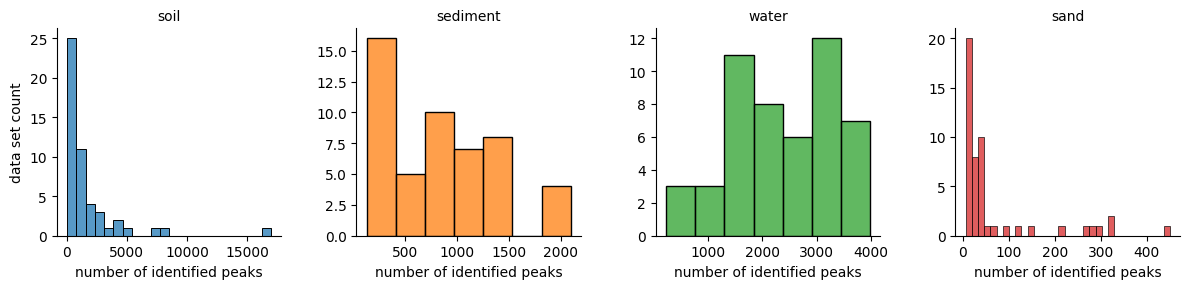

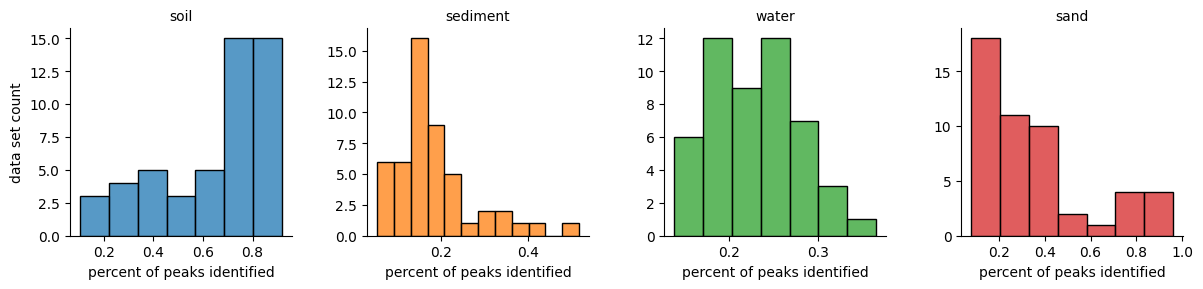

In [20]:
peak_count_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_count_plot.map(sns.histplot,'assigned_peak_count')
peak_count_plot.set_xlabels("number of identified peaks")
peak_count_plot.set_ylabels("data set count")
peak_count_plot.set_titles(col_template="{col_name}")

peak_perc_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_perc_plot.map(sns.histplot,'assigned_perc')
peak_perc_plot.set_xlabels("percent of peaks identified")
peak_perc_plot.set_ylabels("data set count")
peak_perc_plot.set_titles(col_template="{col_name}")

Apply filters to obtain high quality processed NOM data sets without removing all the files from any one sample type. Based on the figures above, requiring files to have at least 250 identified peaks that account for at least 30% of their total peak count will maintain a healthy number of data sets across sample types.

In [21]:
#filter data sets according to stats on peak assignment
nom_filt=nom_summary_df[nom_summary_df['assigned_peak_count']>=250]
nom_filt=nom_filt[nom_filt['assigned_perc']>=0.25]

#expand listed columns in molecular formula df
nom_filt_expanded=nom_filt.explode(['mol_form','H/C','O/C','Confidence Score'])

#resave expanded columns as numeric
nom_filt_expanded['O/C']=pd.to_numeric(nom_filt_expanded['O/C'])
nom_filt_expanded['H/C']=pd.to_numeric(nom_filt_expanded['H/C'])
nom_filt_expanded['Confidence Score']=pd.to_numeric(nom_filt_expanded['Confidence Score'])

#metadata group column
grouping_column='sample_type'

#count number of datasets in each type
count_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates().value_counts(grouping_column)

count_type

sample_type
soil        33
water       15
sediment     8
sand         6
Name: count, dtype: int64

Randomly sample a minimum number of data sets to visualize from each sample type

In [22]:
#determine sampling size based on counts above
n=min(pd.DataFrame(count_type)['count'])

#list the different types
list_type=count_type.index.tolist()

#for each type, randomly sample n data sets and save them into list
nom_sampled=[]
for type in list_type:
    #each processed ID and sample type
    nom_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates()
    #filter to current sample type
    nom_type=nom_type[nom_type[grouping_column]==type]
    #randomly sample n processed IDs in current sample type
    nom_type=nom_type.sample(n=n, random_state=2)
    #save
    nom_sampled.append(nom_type)

#resave list as dataframe
nom_sampled=pd.concat(nom_sampled)

#remerge rest of the data for the sampled data sets
nom_sampled=nom_sampled.merge(nom_filt_expanded,on=['processed',grouping_column],how="left")

nom_sampled

processed sample_type  assigned_peak_count  assigned_perc  \
0      nmdc:dobj-11-ppa60081        soil                 1147       0.648023   
1      nmdc:dobj-11-ppa60081        soil                 1147       0.648023   
2      nmdc:dobj-11-ppa60081        soil                 1147       0.648023   
3      nmdc:dobj-11-ppa60081        soil                 1147       0.648023   
4      nmdc:dobj-11-ppa60081        soil                 1147       0.648023   
...                      ...         ...                  ...            ...   
46456  nmdc:dobj-13-4z27e492        sand                  299       0.810298   
46457  nmdc:dobj-13-4z27e492        sand                  299       0.810298   
46458  nmdc:dobj-13-4z27e492        sand                  299       0.810298   
46459  nmdc:dobj-13-4z27e492        sand                  299       0.810298   
46460  nmdc:dobj-13-4z27e492        sand                  299       0.810298   

           mol_form       H/C       O/C  Confidence Score  
0        C16 H32 O3  2.000000  0.187500          0.599829  
1        C18 H36 O2  2.000000  0.111111          0.597165  
2        C16 H30 O4  1.875000  0.250000          0.594543  
3        C17 H26 O4  1.529412  0.235294          0.599996  
4        C18 H34 O3  1.888889  0.166667          0.599997  
...             ...       ...       ...               ...  
46456    C15 H30 O2  2.000000  0.133333          0.594916  
46457    C15 H28 O2  1.866667  0.133333          0.592847  
46458  C8 H16 O6 S1  2.000000  0.750000          0.046416  
46459    C14 H28 O2  2.000000  0.142857          0.596208  
46460  C7 H12 O6 S1  1.714286  0.857143          0.006649  

[46461 rows x 8 columns]

Filter to high confidence peaks (score greater than 0.3) and high frequency molecular formulas (present in more than 5 data sets). This will leave us with the most informative data.

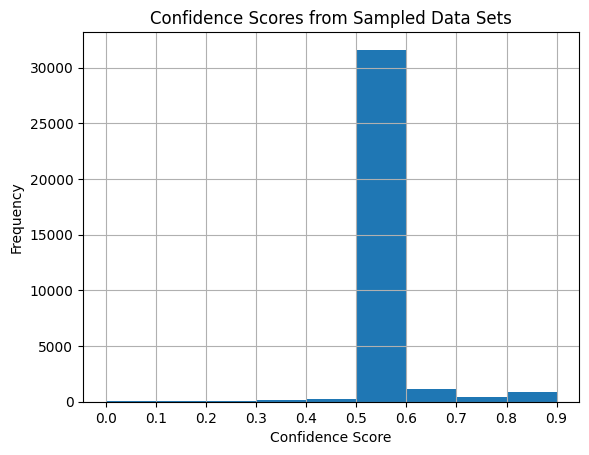

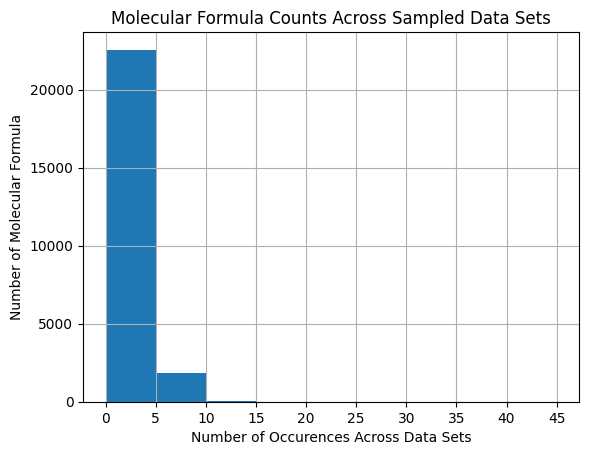

In [23]:
#histogram of confidence scores for randomly selected samples
nom_sampled.hist("Confidence Score",bins=np.arange(0,1,0.1))
plt.title('Confidence Scores from Sampled Data Sets')
plt.xlabel("Confidence Score")
plt.xticks(np.arange(0,1,0.1))
plt.ylabel("Frequency")
plt.show()

#peak filtering by confidence score
conf_filt=nom_sampled[nom_sampled['Confidence Score']>=0.3]

#count for each molecular formula
mol_counts=conf_filt.value_counts('mol_form').to_frame().reset_index()

#histogram of molecular formula counts
mol_counts.hist("count",bins=np.arange(0,50,5))
plt.locator_params(axis='x')
plt.title('Molecular Formula Counts Across Sampled Data Sets')
plt.xlabel("Number of Occurences Across Data Sets")
plt.xticks(np.arange(0,50,5))
plt.ylabel("Number of Molecular Formula")
plt.show()

#based on this histogram, filter to formulas in more than 5 data sets
mol_counts=mol_counts[mol_counts['count']>=5]
mol_filter=mol_counts.merge(conf_filt,on=['mol_form'],how="left")


### Assess patterns in the molecular formulas from different sample types

Create a clustermap of the processed NOM data sets (x axis), indicating the presence (black) or absence (white) of molecular formulas (y axis). The color bar will indicate sample type and help visualize the molecular similarity of data sets both within and between sample types.  

/home/bmeluch/NMDC/notebooks/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/bmeluch/NMDC/notebooks/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


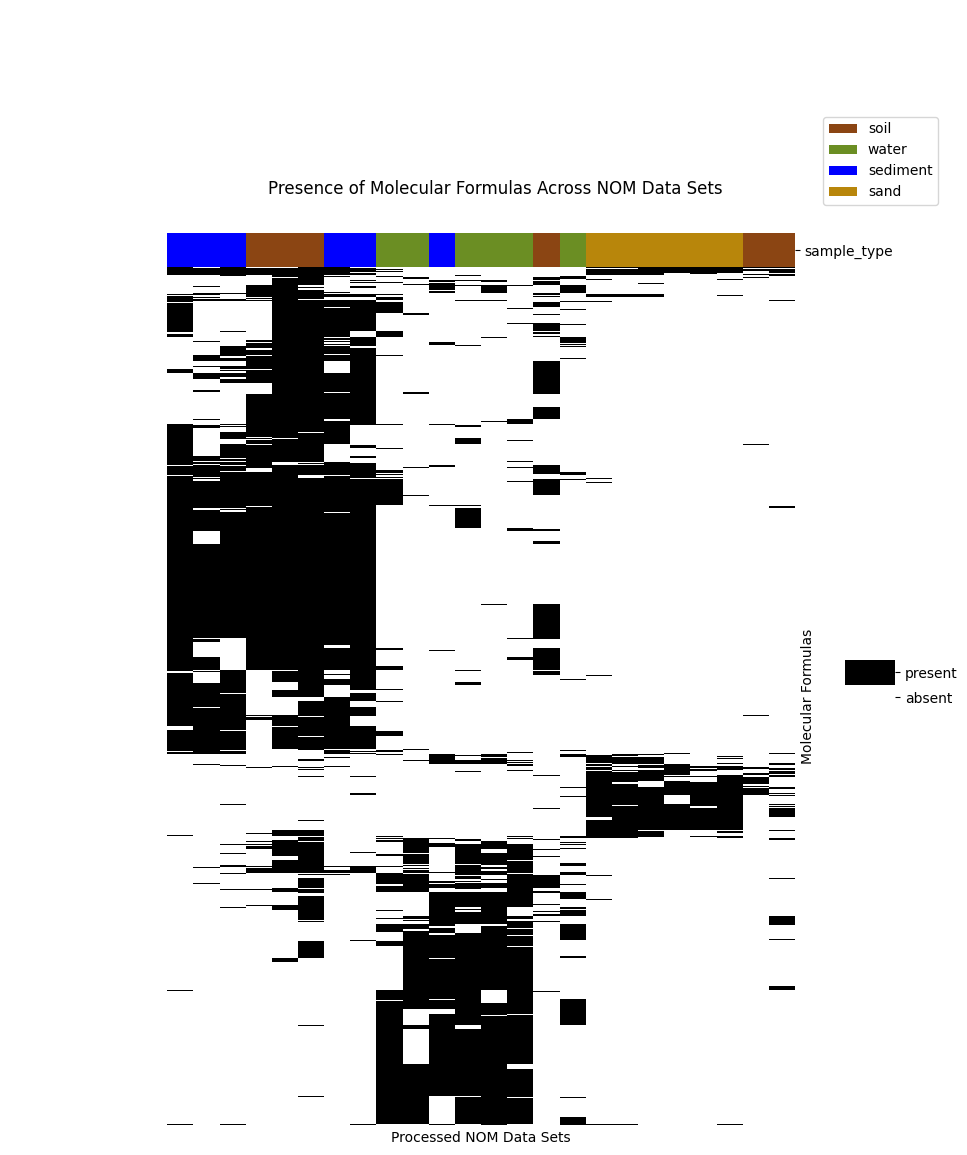

In [24]:
#sample type colors

#set colors for each sample type
type_col=pd.DataFrame({grouping_column:mol_filter[grouping_column].unique(),'color':['#8B4513','olivedrab','blue','#B8860B']})

#setup color legend for sample type
type_col_dict = dict(zip(type_col[grouping_column].unique(), ['#8B4513','olivedrab','blue','#B8860B']))
handles = [Patch(facecolor=type_col_dict[name]) for name in type_col_dict]

#map graph colors based on sample type to processed IDs
sample_type=mol_filter[[grouping_column,'processed']].drop_duplicates()
sample_type_col=sample_type.merge(type_col,how='left',on=grouping_column).set_index('processed').drop(grouping_column,axis=1).rename(columns={'color':grouping_column})

#presence/absence

#set colors for presence/absence as cmap
colors=['white','black']
custom_palette = sns.color_palette(colors)
custom_cmap = sns.color_palette(custom_palette, as_cmap=True)

#add column indicating presence in that processed nom id (1 is present)
mol_filter['presence']=1

#create presence/absence matrix. replace NA with 0 (0 is absent)
formula_matrix=mol_filter[['mol_form','processed','presence']].pivot_table('presence', index='mol_form', columns='processed').fillna(0).astype(int)

#heatmap (1 is present, zero is absent)
g=sns.clustermap(data=formula_matrix,col_colors=sample_type_col,tree_kws={"linewidths": 0.},xticklabels=False,yticklabels=False,cmap=custom_cmap)
g.figure.suptitle("Presence of Molecular Formulas Across NOM Data Sets")
g.ax_heatmap.set_xlabel("Processed NOM Data Sets")
g.ax_heatmap.set_ylabel("Molecular Formulas")

#adjust plot and legend locations
g.figure.subplots_adjust(top=1.15,right=0.8)
g.ax_cbar.set_position((0.85, 0.45, .05, .05)) #x axis,y axis, width, height

#adjust cbar legend to indicate presence/absence
g.ax_cbar.set_yticks([0.25,0.75])
g.ax_cbar.set_yticklabels(["absent","present"])

#add sample type legend
plt.legend(handles, type_col_dict, title=None,
           bbox_to_anchor=(0.95, 1.05), bbox_transform=plt.gcf().transFigure)

Create Van Krevelen diagrams to visually assess the atomic composition of each sample type. Van Krevelen diagrams plot the hydrogen to carbon ratio against the oxygen to carbon ratio, historically to assess petroleum samples.

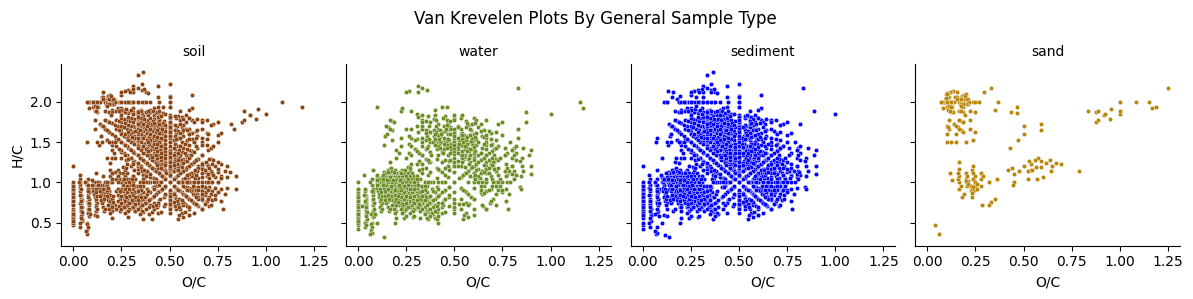

In [25]:
# the same molecular formula will have the same H/C and O/C value in every data set, so dots are only unique per sample type
vankrev_data=mol_filter[[grouping_column,'mol_form','H/C','O/C']].drop_duplicates()

#make van krevlen plot
g=sns.FacetGrid(vankrev_data,col=grouping_column,hue=grouping_column,palette=type_col_dict)
g.map(sns.scatterplot,'O/C','H/C',s=10)
g.set_titles(col_template="{col_name}")
g.figure.suptitle("Van Krevelen Plots By General Sample Type")
g.figure.subplots_adjust(top=0.8)

Create marginal density plot to assess how molecular formulas unique to each sample type compare to those shared by all four sample types.

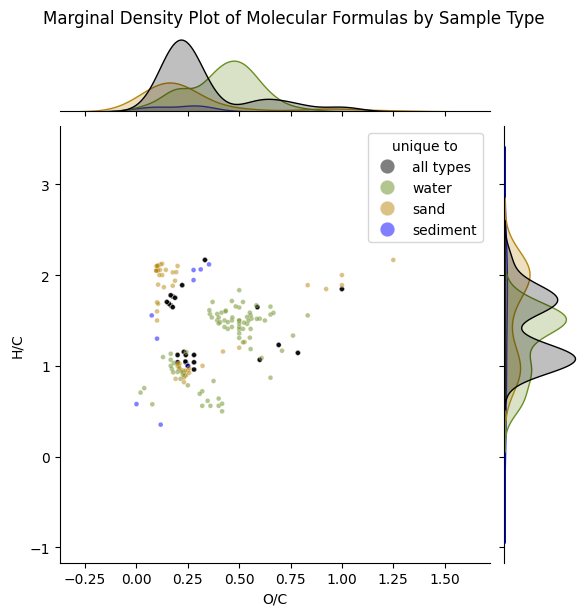

In [26]:
#count the number of sample types in which each molecular formula is found
density_counts=vankrev_data['mol_form'].value_counts()

#map counts back to H/C and O/C data
vankrev_data['common_to'] = vankrev_data['mol_form'].map(density_counts)

#filter molecular formual present in either all four sample types or in only one
vankrev_data=vankrev_data[vankrev_data['common_to'].isin([1,4])]

#reformat so sample type is 'all' when molecular formula was in all
vankrev_data.loc[vankrev_data['common_to']==4,'sample_type']='all types'

#add 'all' to sample type color dictionary
type_col_dict.update({'all types':'black'})

#make marginal density plot
sns.jointplot(data=vankrev_data, x="O/C", y="H/C", kind="scatter", hue=grouping_column,palette=type_col_dict,s=12,alpha=0.5)
plt.legend(markerscale=3,title="unique to")
plt.suptitle("Marginal Density Plot of Molecular Formulas by Sample Type",y=1.02)
plt.show()
